# **CARGA DE DATOS Y LIBRERÍAS**

In [1]:
from google.colab import files

# Despliega el cuadro de diálogo para subir archivos
uploaded = files.upload()

# Listar los archivos subidos (opcional)
for file_name in uploaded.keys():
    print(f'Archivo subido: {file_name}')

Saving kaggle.json to kaggle.json
Archivo subido: kaggle.json


In [2]:
# Crea la carpeta .kaggle y mueve el archivo kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Cambia los permisos para el archivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Instala la Kaggle CLI
!pip install -q kaggle

# Descarga el dataset utilizando el identificador del nuevo dataset
!kaggle datasets download -d shreyag1103/brain-mri-scans-for-brain-tumor-classification

# Descomprimir el archivo descargado
!unzip -q brain-mri-scans-for-brain-tumor-classification.zip -d /content/brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/shreyag1103/brain-mri-scans-for-brain-tumor-classification
License(s): unknown
 98% 24.0M/24.4M [00:00<00:00, 110MB/s] 
100% 24.4M/24.4M [00:00<00:00, 96.3MB/s]


In [4]:
import os
import shutil
import random
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from PIL import Image
import math
import pandas as pd
import itertools

# **CLASIFICACIÓN Y PREDICCIÓN CON PYTORCH**

In [4]:
# Directorio original de las imágenes
original_data_dir = '/content/brain_tumor_dataset/data'

# Nombres de las carpetas con las imágenes
folders = os.listdir(original_data_dir)

# Proporción de imágenes para el conjunto de validación
val_split = 0.2

# Crear el directorio para los datos divididos
split_data_dir = '/content/split_data'
os.makedirs(split_data_dir, exist_ok=True)

# Iterar sobre las carpetas y dividir las imágenes
for folder in folders:
    folder_path = os.path.join(original_data_dir, folder)
    images = os.listdir(folder_path)

    # Dividir las imágenes en train y val
    random.shuffle(images)
    split_index = int(len(images) * (1 - val_split))
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Crear directorios para train y val en el directorio dividido
    train_dir = os.path.join(split_data_dir, 'train', folder)
    val_dir = os.path.join(split_data_dir, 'val', folder)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Copiar las imágenes a los directorios correspondientes
    for image in train_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(train_dir, image)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(val_dir, image)
        shutil.copy(src, dst)

print("División completa.")



División completa.


In [74]:
# Directorio de datos divididos
split_data_dir = '/content/split_data'

# Contadores para train y val
train_count = 0
val_count = 0

# Iterar sobre las carpetas de train y val y contar imágenes
for folder in ['train', 'val']:
    for subfolder in os.listdir(os.path.join(split_data_dir, folder)):
        folder_path = os.path.join(split_data_dir, folder, subfolder)
        num_images = len(os.listdir(folder_path))
        if folder == 'train':
            train_count += num_images
        elif folder == 'val':
            val_count += num_images

print(f"El número total de imágenes en train es: {train_count}")
print(f"El número total de imágenes en val es: {val_count}")


El número total de imágenes en train es: 1048
El número total de imágenes en val es: 263


In [75]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = split_data_dir
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [76]:
# Carga el modelo con pesos preentrenados específicos
weights = ResNet18_Weights.DEFAULT  # Utiliza los pesos más actualizados disponibles
model = resnet18(weights=weights)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # Asumiendo que hay 4 categorías

if torch.cuda.is_available():
    model = model.cuda()



In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [78]:
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

# Comenzar el entrenamiento
model = train_model(model, criterion, optimizer, num_epochs=25)


Epoch 0/24
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 0.8278 Acc: 0.6718
val Loss: 0.3138 Acc: 0.8897

Epoch 1/24
----------
train Loss: 0.5002 Acc: 0.8149
val Loss: 0.1867 Acc: 0.9278

Epoch 2/24
----------
train Loss: 0.4651 Acc: 0.8406
val Loss: 0.2834 Acc: 0.9125

Epoch 3/24
----------
train Loss: 0.3341 Acc: 0.8874
val Loss: 0.1549 Acc: 0.9430

Epoch 4/24
----------
train Loss: 0.2064 Acc: 0.9198
val Loss: 0.1714 Acc: 0.9468

Epoch 5/24
----------
train Loss: 0.2129 Acc: 0.9303
val Loss: 0.1371 Acc: 0.9620

Epoch 6/24
----------
train Loss: 0.2197 Acc: 0.9370
val Loss: 0.2317 Acc: 0.9354

Epoch 7/24
----------
train Loss: 0.2360 Acc: 0.9284
val Loss: 0.2075 Acc: 0.9240

Epoch 8/24
----------
train Loss: 0.1292 Acc: 0.9571
val Loss: 0.1989 Acc: 0.9468

Epoch 9/24
----------
train Loss: 0.1988 Acc: 0.9447
val Loss: 0.1410 Acc: 0.9582

Epoch 10/24
----------
train Loss: 0.2033 Acc: 0.9399
val Loss: 0.1660 Acc: 0.9392

Epoch 11/24
----------
train Loss: 0.1556 Acc: 0.9532
val Loss: 0.3513 Acc: 0.8935

Epoch 12/24
----------
t

In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y traza el mapa de confusión.
    La normalización se puede aplicar configurando `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión Normalizada")
    else:
        print('Matriz de Confusión Sin Normalizar')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta Actual')
    plt.xlabel('Etiqueta Predicha')


In [80]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Suponiendo que tienes un dataloader para la validación
labels, preds = evaluate_model(model, dataloaders['val'])


Matriz de Confusión Sin Normalizar
[[55  5  0  0]
 [ 1 57  0  4]
 [ 0  2 79  0]
 [ 0  0  0 60]]


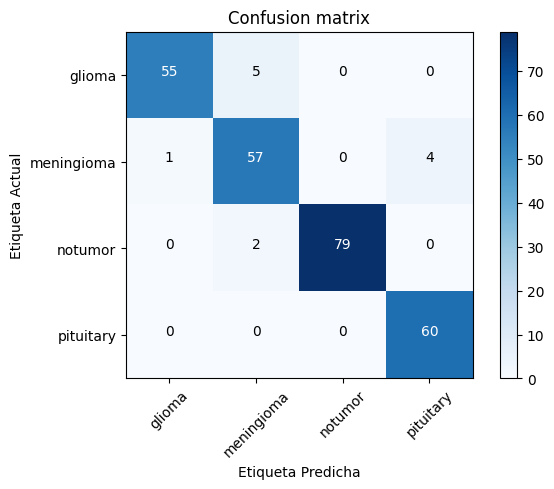

In [81]:
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, class_names)
plt.show()

In [82]:
# Asumiendo que la función evaluate_model ya está definida y que devuelve labels y preds
labels, preds = evaluate_model(model, dataloaders['val'])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [83]:
import pandas as pd
# Crear DataFrame
results_df = pd.DataFrame({'Etiqueta Actual': labels, 'Etiqueta Predicha': preds})

# Reemplazar los enteros por nombres de las clases si es necesario
class_names_mapping = {index: name for index, name in enumerate(class_names)}
results_df.replace({'Etiqueta Actual': class_names_mapping, 'Etiqueta Predicha': class_names_mapping}, inplace=True)

# Mostrar las primeras filas de la tabla para verificar
results_df.head(20)


,Etiqueta Actual,Etiqueta Predicha
0,pituitary,pituitary
1,glioma,glioma
2,meningioma,meningioma
3,glioma,glioma
4,pituitary,pituitary
5,glioma,glioma
6,meningioma,meningioma
7,pituitary,pituitary
8,pituitary,pituitary
9,pituitary,pituitary


In [84]:
def predict_image(image_path, model, class_names, transform):
    image = Image.open(image_path)
    image = image.convert('RGB')  # Convertir a RGB si es necesario
    image = transform(image).unsqueeze(0)  # Añadir una dimensión de batch

    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            image = image.cuda()
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1) * 100
        predicted_label = class_names[preds[0]]
        probability = probabilities[0, preds[0]].item()

    print(f'Etiqueta Predicha: {predicted_label}')
    print(f'Probability: {probability:.2f}%')

    # Mostrar la imagen
    plt.imshow(Image.open(image_path))
    plt.title(f'{predicted_label} ({probability:.2f}%)')
    plt.show()

# Transformaciones necesarias
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Etiqueta Predicha: glioma
Probability: 100.00%


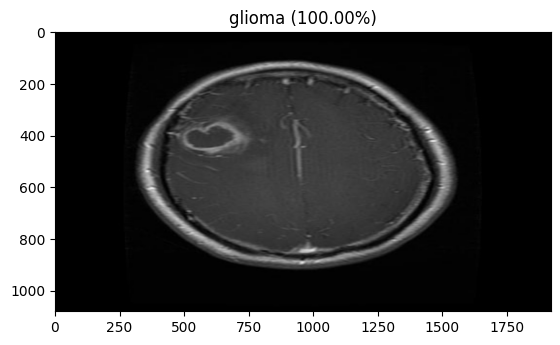

In [85]:
# Asumimos que 'model' y 'class_names' están definidos
image_path = '/content/PRUEBA GL.png'  # Reemplaza esto con la ruta real a tu imagen
predict_image(image_path, model, class_names, transform)


Etiqueta Predicha: meningioma
Probability: 100.00%


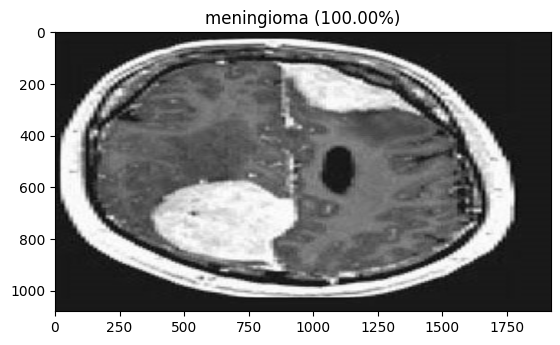

In [86]:
# Asumimos que 'model' y 'class_names' están definidos
image_path = '/content/PRUEBA MEN.png'  # Reemplaza esto con la ruta real a tu imagen
predict_image(image_path, model, class_names, transform)

Etiqueta Predicha: pituitary
Probability: 100.00%


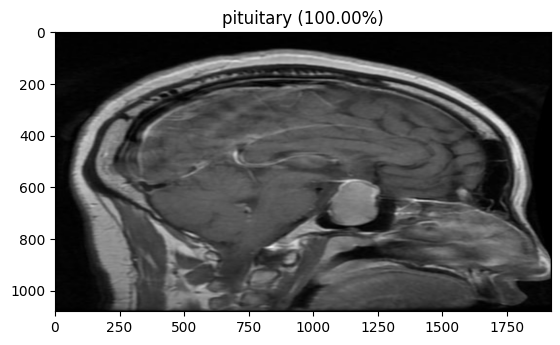

In [87]:
# Asumimos que 'model' y 'class_names' están definidos
image_path = '/content/PRUEBA PI.png'  # Reemplaza esto con la ruta real a tu imagen
predict_image(image_path, model, class_names, transform)

Etiqueta Predicha: notumor
Probability: 99.89%


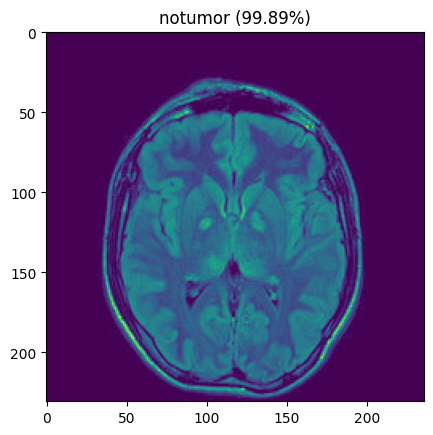

In [88]:
# Asumimos que 'model' y 'class_names' están definidos
image_path = '/content/PRUEBA NO CANCER.png'  # Reemplaza esto con la ruta real a tu imagen
predict_image(image_path, model, class_names, transform)

## **Investigar Casos de Error**

In [89]:
# Obtener los índices de los casos donde las predicciones fueron incorrectas
incorrect_indices = [i for i, (pred, actual) in enumerate(zip(preds, labels)) if pred != actual]
print(f"Número de predicciones incorrectas: {len(incorrect_indices)}")


Número de predicciones incorrectas: 12


 LAS QUE NO COINCIDA EL NOMBRE EN AMBAS COLUMNAS SE IMPRIMA SU FOTO CORRESPONDIENTE JUNTO EN EL TITULO SU ETIQUETA PRECHA Y ACTUAL

In [90]:
# Filtrar el DataFrame para obtener solo las filas donde las etiquetas no coinciden
mismatches = results_df[results_df['Etiqueta Actual'] != results_df['Etiqueta Predicha']]
mismatches

,Etiqueta Actual,Etiqueta Predicha
10,glioma,meningioma
31,meningioma,pituitary
36,glioma,meningioma
41,glioma,meningioma
51,glioma,meningioma
123,glioma,meningioma
129,meningioma,pituitary
132,meningioma,pituitary
151,meningioma,glioma
163,notumor,meningioma


In [91]:
# Reconstruir rutas de imágenes desde el conjunto de datos
image_paths = [image_datasets['val'].imgs[idx][0] for idx in range(len(image_datasets['val']))]


In [92]:
# Obtener rutas de imágenes que corresponden a las filas de discrepancias en el DataFrame
mismatched_image_paths = [image_paths[idx] for idx in mismatches.index]


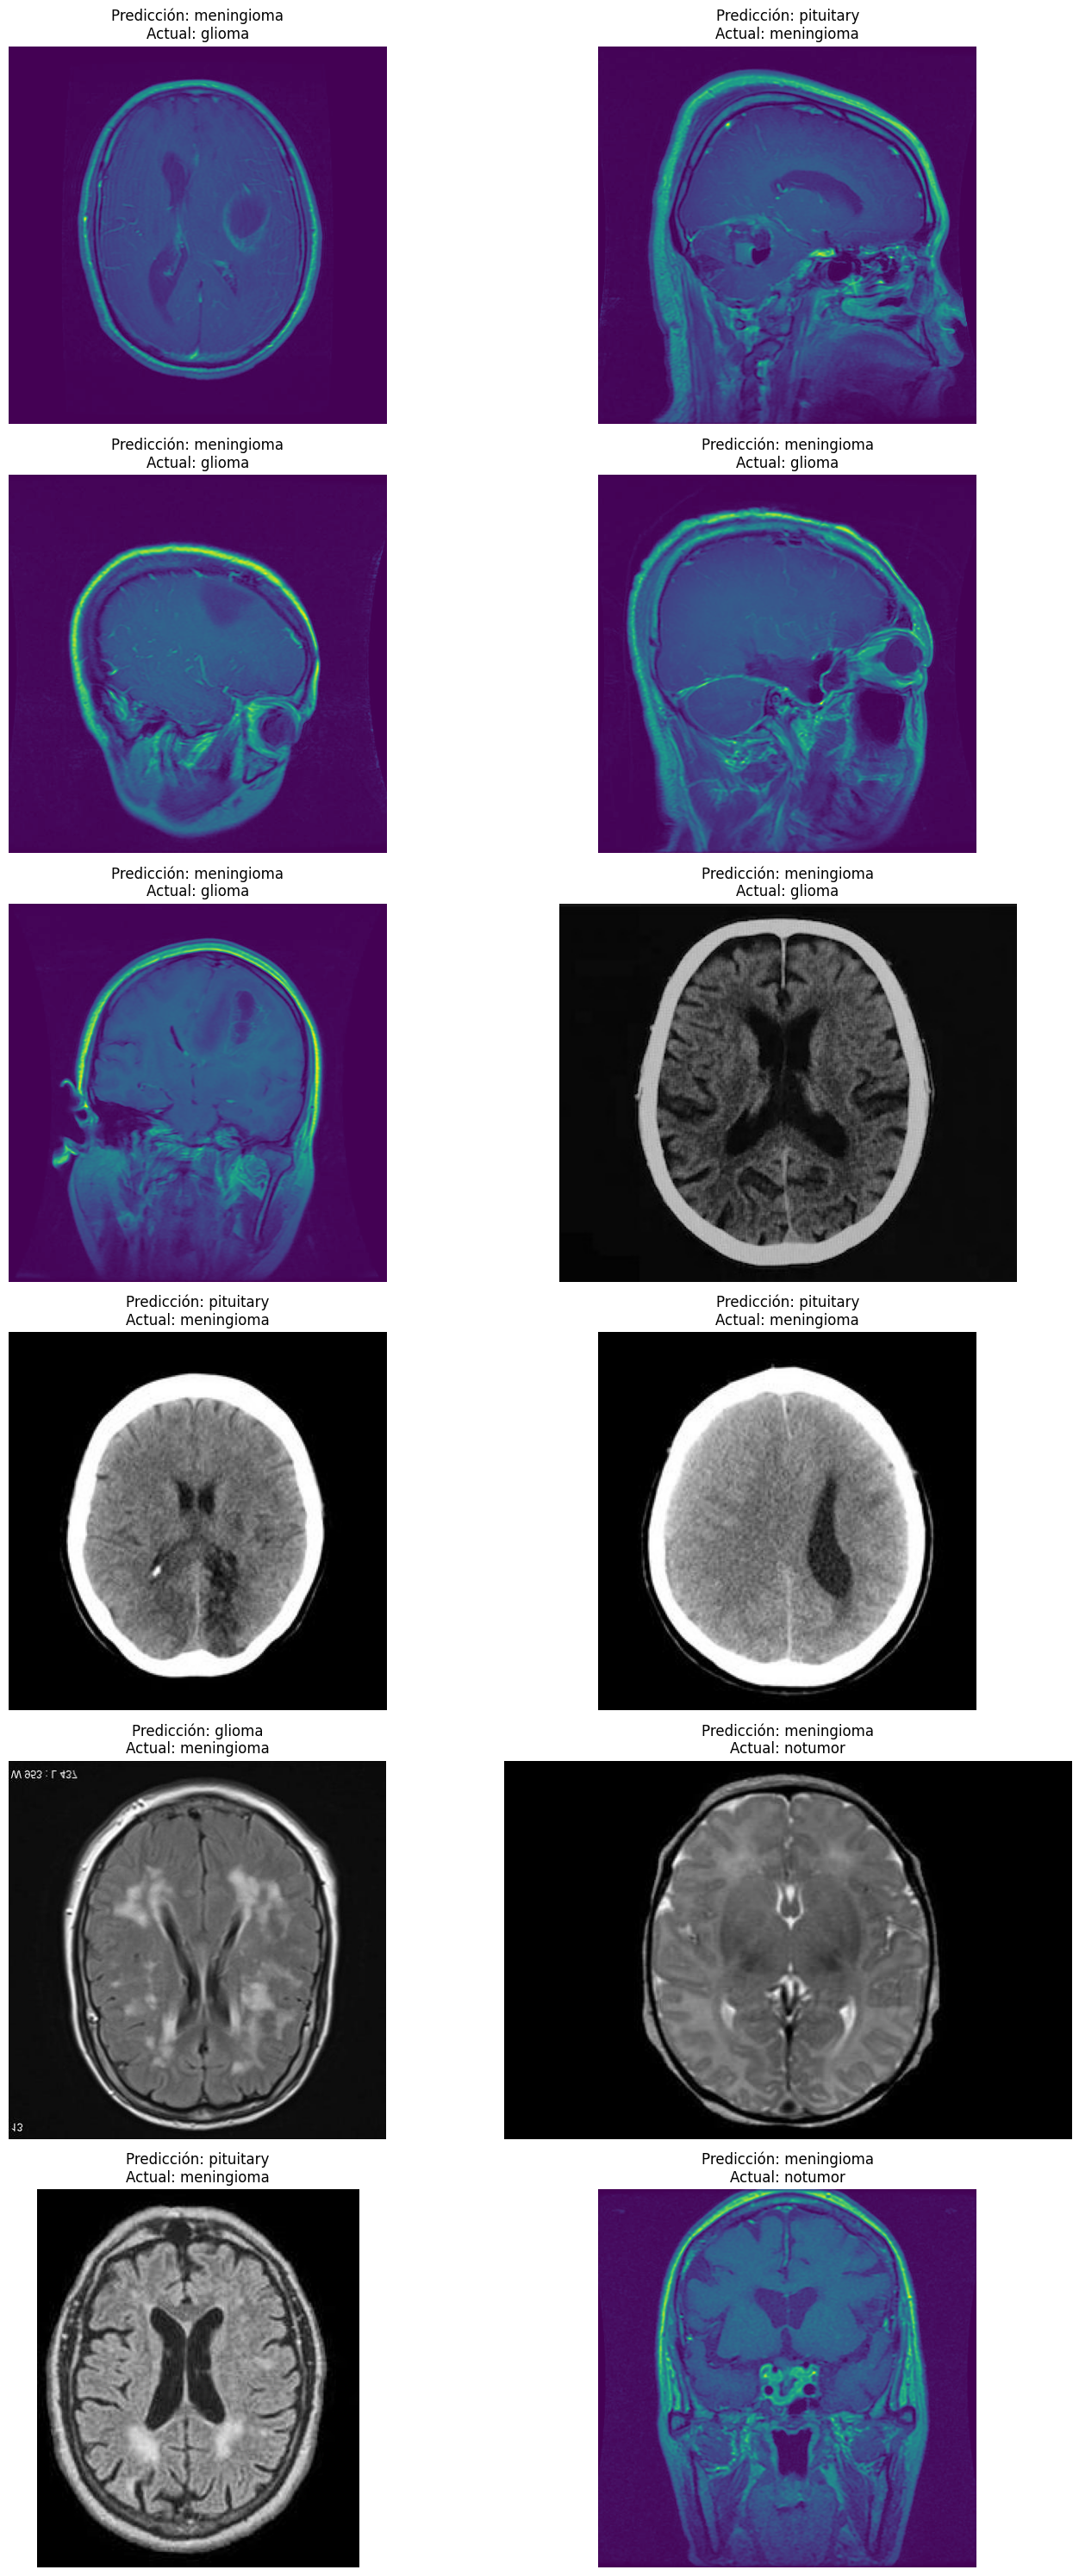

In [95]:
def show_mismatched_images(mismatches, mismatched_image_paths):
    num_images = len(mismatches)
    num_cols = 2
    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), squeeze=False)

    for ax, (idx, row), img_path in zip(axs.flatten(), mismatches.iterrows(), mismatched_image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        title = f"Predicción: {row['Etiqueta Predicha']}\nActual: {row['Etiqueta Actual']}"
        ax.set_title(title)
        ax.axis('off')

    # Eliminar ejes adicionales si el número de imágenes no es un múltiplo de num_cols
    for ax in axs.flatten()[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Llamada a la función con los datos correctos
show_mismatched_images(mismatches, mismatched_image_paths)




Los que más se confunden son meningioma con pituitario y glioma.